## Packages

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [ ]:
 # Ensure project root (with src/) is on sys.path so imports like `from src...` work in notebooks
import sys
from pathlib import Path
p = Path.cwd()
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        project_root = Path.cwd()
        break
    p = p.parent
else:
    project_root = Path.cwd()
# Insert at front so local src/ takes precedence
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f'Added project root to sys.path: {project_root}')

Added project root to sys.path: c:\Users\jarno\Downloads\stock-predictor-1


## Input Parameters

In [ ]:
ticker = "META"
start_date = "2019-01-01"
rsi_period = 14
periods = [20, 50, 200]
start_plot_date = "2025-01-01"
df = yf.download(ticker, start=start_date, interval="1d")
close_df = df[['Close']].copy()

C:\Users\jarno\AppData\Local\Temp\ipykernel_4692\2951064163.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, interval="1d")
[*********************100%***********************]  1 of 1 completed


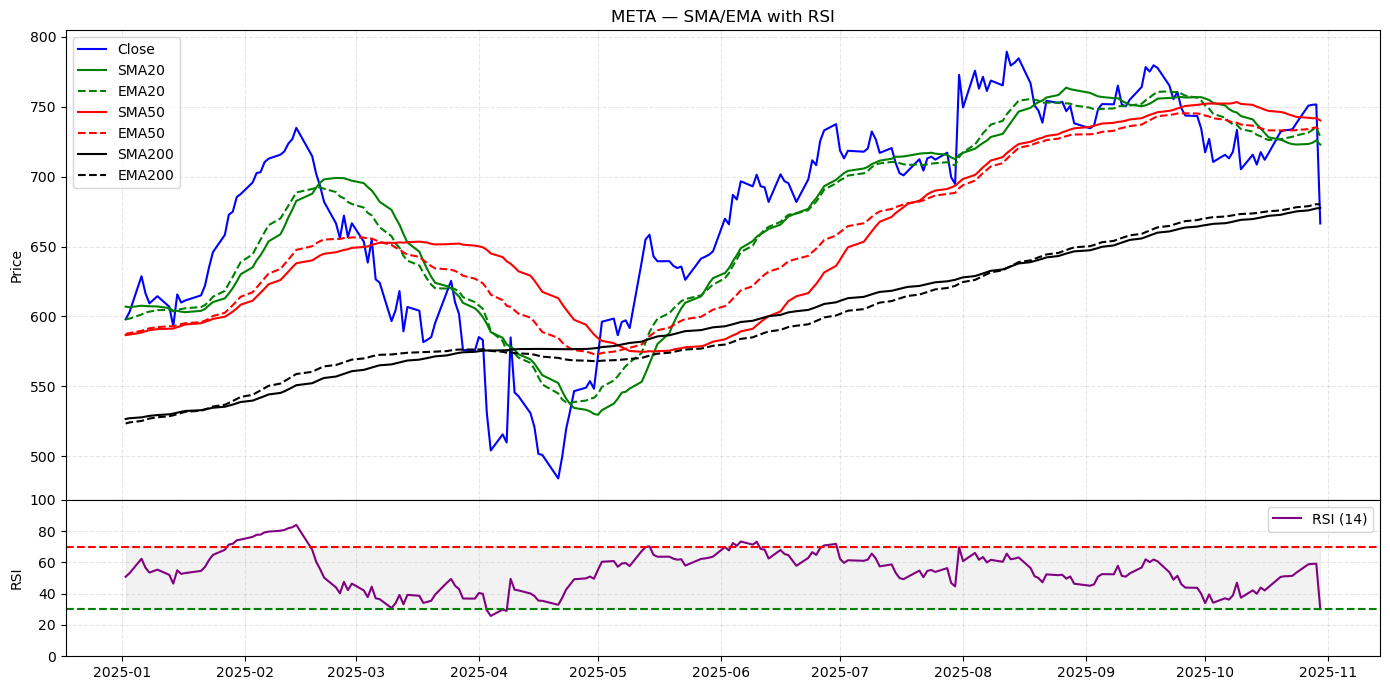

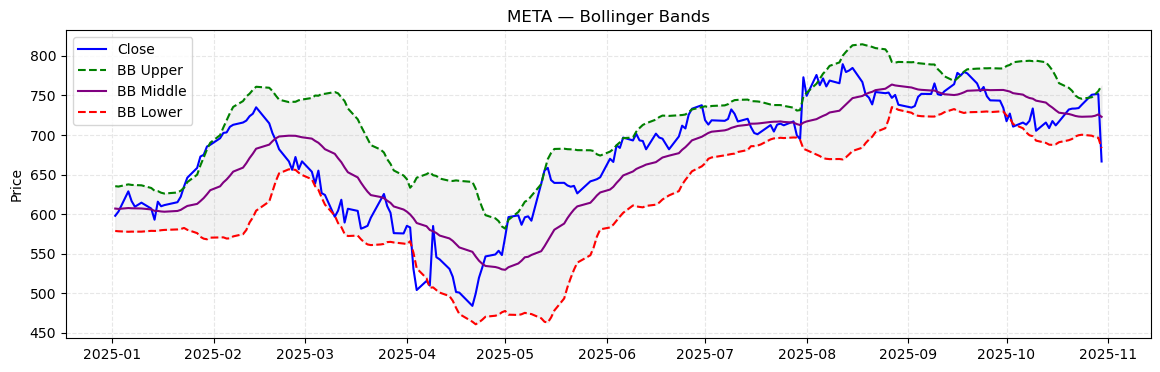

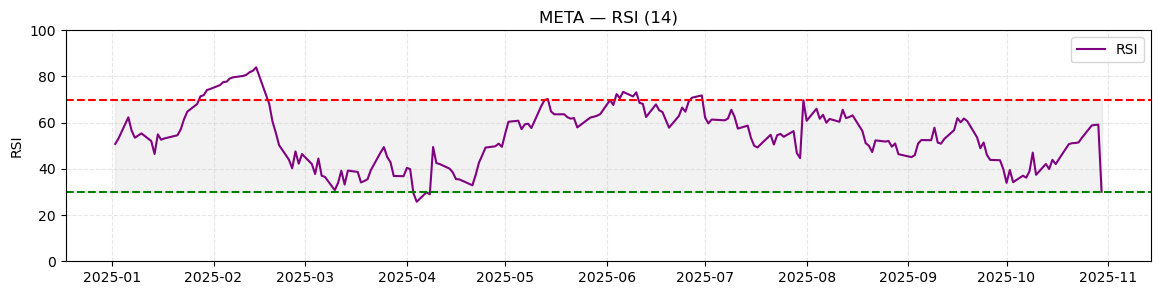

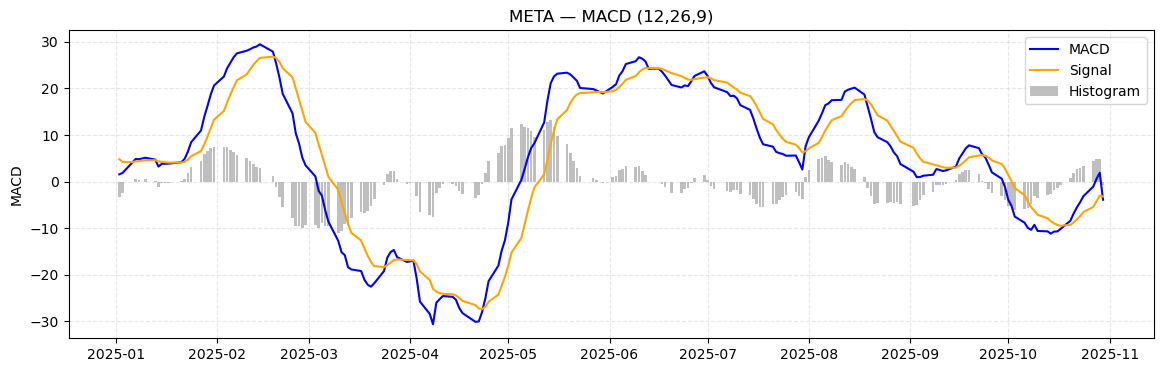

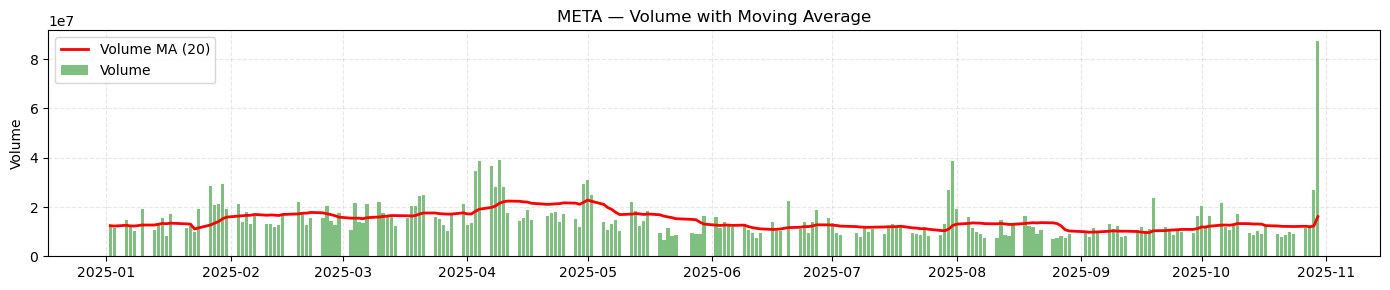

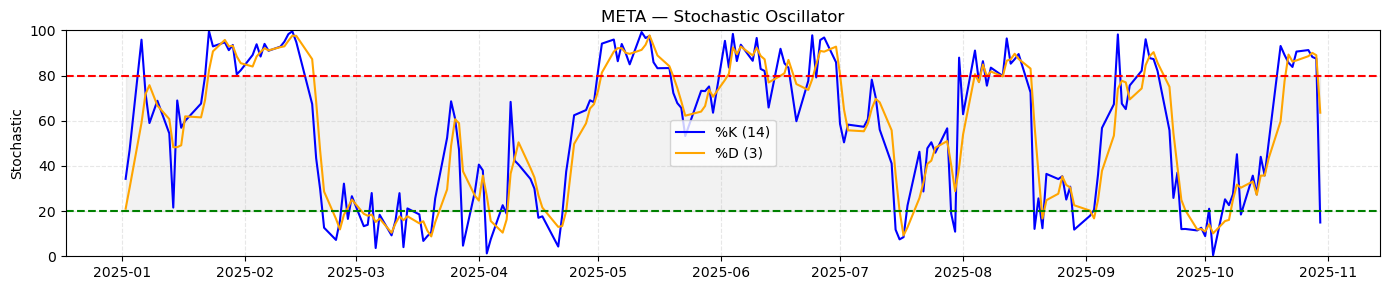

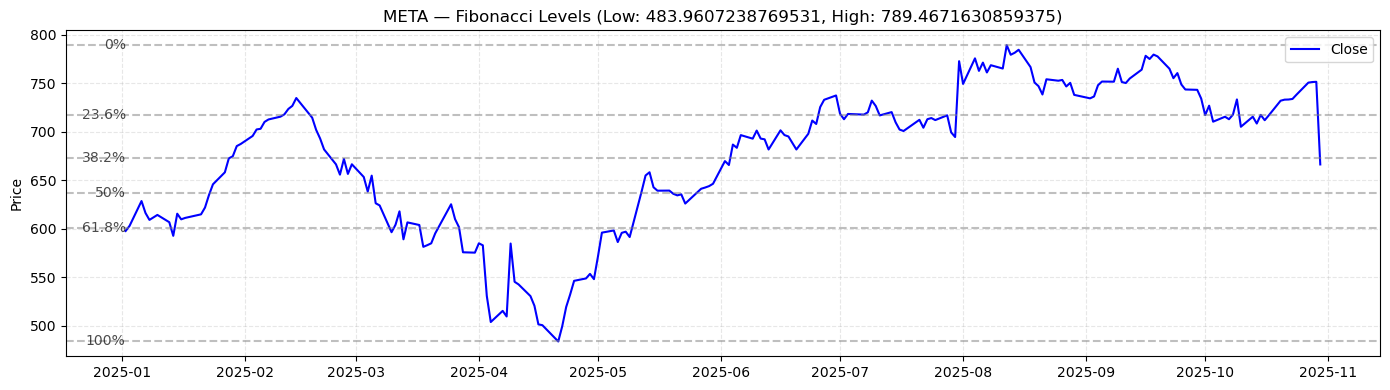

In [ ]:
from src.plot_indicators import plot_sma_ema_with_rsi, plot_bollinger_bands, plot_rsi, plot_macd, plot_full_chart, plot_volume, plot_stochastic, plot_fibonacci_levels, plot_monthly_candles

plot_sma_ema_with_rsi(df, ticker, start_plot_date=start_plot_date)
plot_bollinger_bands(df, ticker, start_plot_date=start_plot_date)
plot_rsi(df, ticker, start_plot_date=start_plot_date)
plot_macd(df, ticker, start_plot_date=start_plot_date)

plot_volume(df, ticker, start_plot_date=start_plot_date)
plot_stochastic(df, ticker, start_plot_date=start_plot_date)
plot_fibonacci_levels(df, ticker, start_plot_date=start_plot_date, auto_detect=True, lookback_period=150)


## SMA, EMA, BB printing

In [ ]:
from src.technische_indicatoren import technische_indicatoren
technische_indicatoren(close_df, periods)

Laatste waarden voor alle indicatoren (datum: 2025-10-30):
- SMA20: 722.92
- EMA20: 728.62
- SMA50: 740.20
- EMA50: 732.67
- SMA200: 677.63
- EMA200: 680.15
- BB_Upper: 762.55
- BB_Middle: 722.92
- BB_Lower: 683.30


## Summary output Technical analysis

In [ ]:
from src.summary_analysis import summary_technical_indicators
summary_technical_indicators(ticker, df, rsi_period, periods, start_plot_date);

Analyse voor **META** (laatste datum: 2025-10-30):
- RSI (14): 30.10 → **Neutraal**
- Bollinger Bands: **Onder onderste band (mogelijk oversold, bullish)**
- MACD (12,26,9): **Bearish (MACD onder signaallijn, verkoopsignaal)**
- SMA/EMA (20, 50, 200): **Sterk bearish (koers onder alle SMA/EMA)**



c:\Users\jarno\Downloads\stock-predictor-1\src\plot_indicators.py:188: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


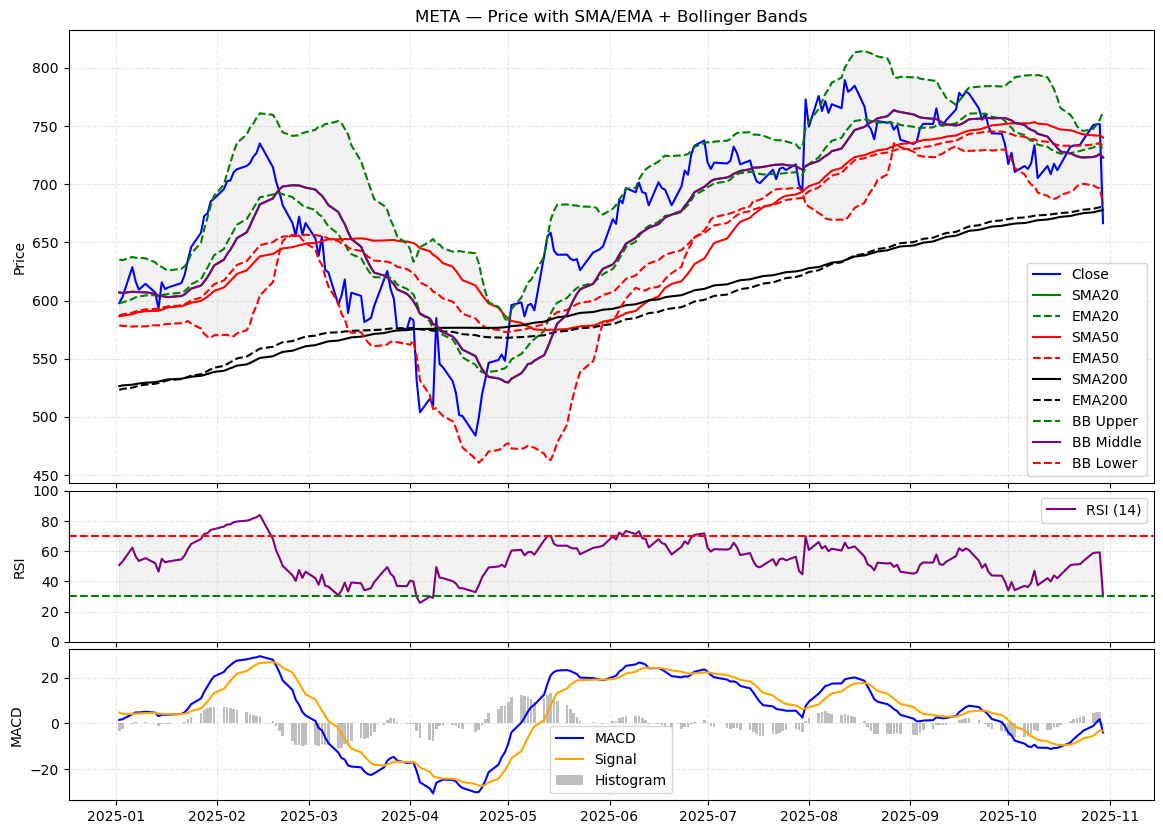

Plotted META with indicators: SMA: [20, 50, 200], EMA: [20, 50, 200], Bollinger Bands: period=20, std=2, RSI: period=14, MACD: fast=12, slow=26, signal=9


In [ ]:
plot_full_chart(df, ticker, [20, 50, 200], start_plot_date, sma=True, ema=True);

# Fugro:
- Sell order: EMA50, RSI +- 60. Houd MACD in de gaten, moet bullish niveau blijven aangeven

## RSI predictor plot

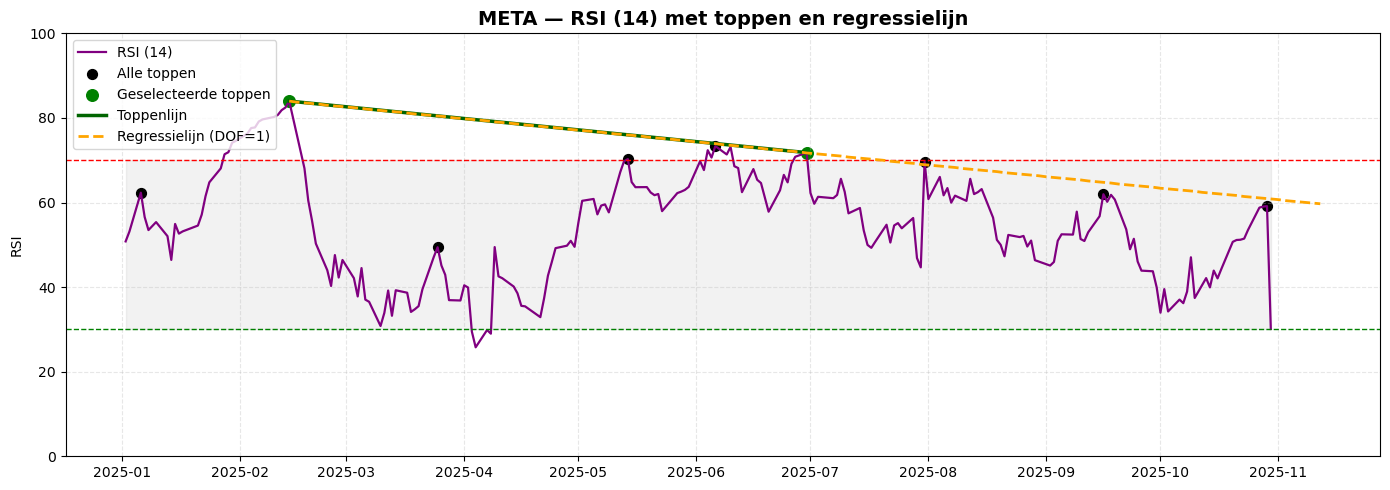

In [ ]:
from src.RSI_predictor import plot_rsi_peaks
plot_rsi_peaks(df, rsi_period, start_plot_date, ticker, 
                                   dof=1, future_days=135, selected_peak_indices= [1,5])

## Monthly candle

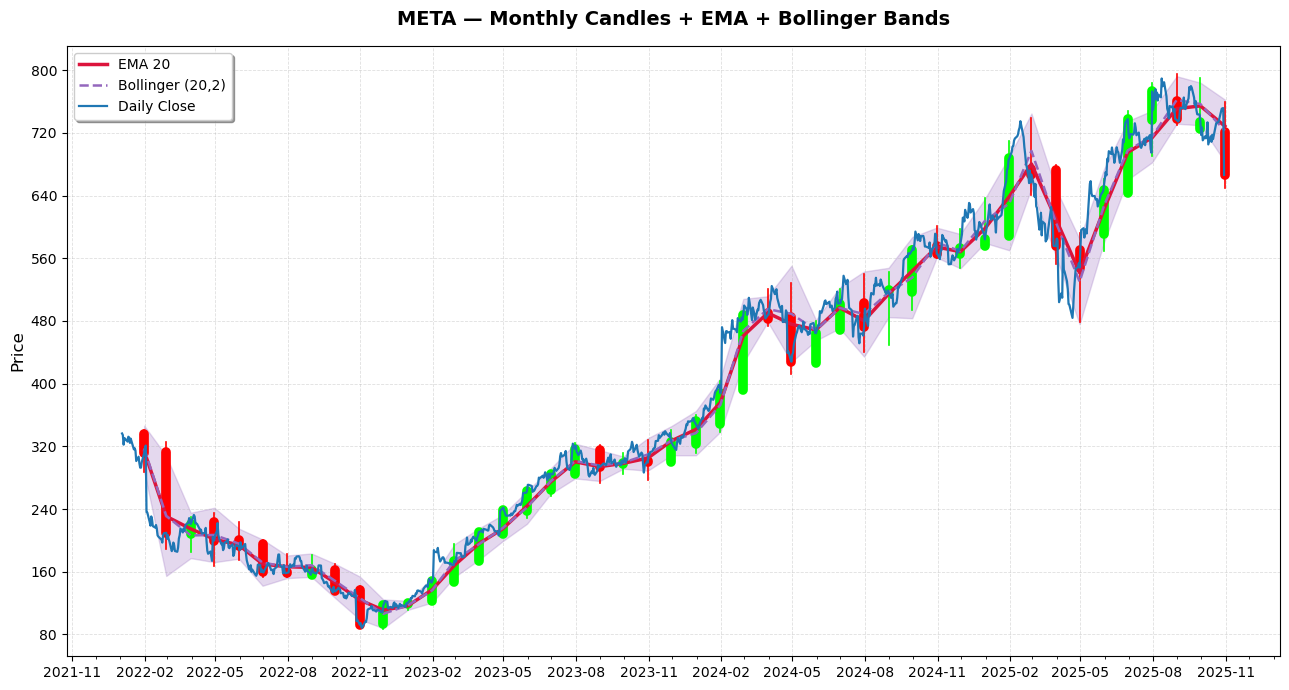

In [ ]:
plot_monthly_candles(df, ticker, start_plot_date="2022-01-01")

## Rebound or trendswitch

In [ ]:
from src.tryout import assess_trend
df_rebound_test = df
if isinstance(df_rebound_test.columns, pd.MultiIndex):
    df_rebound_test.columns = [col[0] for col in df_rebound_test.columns]

assess_trend(df_rebound_test, start_plot_date, rsi_period=rsi_period, periods=periods, plot=False)

'Uncertain or Continuing Trend'